# Import Libraries

In [4]:
import math
import random
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import time

import matplotlib.pyplot as plt

import pickle
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func


from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,Matern,RationalQuadratic,ExpSineSquared,DotProduct
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

# Result storage

In [5]:
results_overview = {}
predictions_per_model = {}

# Data Loading

In [8]:
df_data_train = pd.read_csv('breast-cancer-diagnostic.shuf.lrn.csv', low_memory=False, sep=',')
df_data_res = pd.read_csv('breast-cancer-diagnostic.shuf.tes.csv', low_memory=False, sep=',')


class_factor = df_data_train['MALIGNANT'].factorize()
class_index = class_factor[1]


df_data_train = df_data_train.replace('?', np.nan)
# drop the NaN
df_data_train = df_data_train.dropna(axis=0, how="any")

output_train=df_data_train['MALIGNANT']

X = df_data_train.drop(labels=['MALIGNANT'], axis=1)

#X= preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, output_train, random_state = 0, test_size=0.33)


df_data_res = df_data_res.replace('?', np.nan)
# drop the NaN
X_res = df_data_res.dropna(axis=0, how="any")


In [9]:
df_data_train.head()

,ID,MALIGNANT,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,868682,False,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.02875,...,12.32,22.02,79.93,462.0,0.1190,0.1648,0.1399,0.08476,0.2676,0.06765
1,881972,True,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.10900,...,19.59,24.89,133.50,1189.0,0.1703,0.3934,0.5018,0.25430,0.3109,0.09061
2,901315,False,10.57,20.22,70.15,338.3,0.09073,0.16600,0.22800,0.05941,...,10.85,22.82,76.51,351.9,0.1143,0.3619,0.6030,0.14650,0.2597,0.12000
3,9112367,False,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,...,14.35,34.23,91.29,632.9,0.1289,0.1063,0.1390,0.06005,0.2444,0.06788
4,8711202,True,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,...,20.47,25.11,132.90,1302.0,0.1418,0.3498,0.3583,0.15150,0.2463,0.07738


## Class Distribution

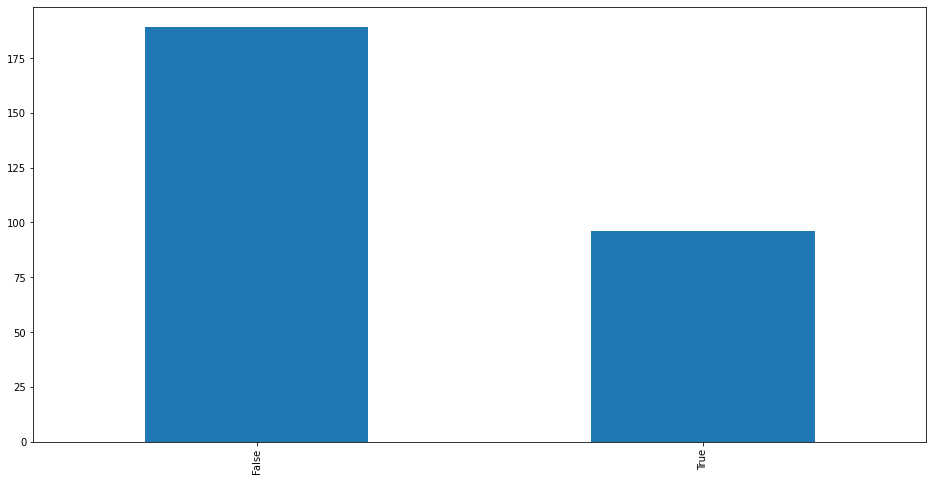

False    189
True      96
Name: MALIGNANT, dtype: int64

2

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
output_train.value_counts().plot(kind='bar')
plt.show()

display(output_train.value_counts())
display(len(output_train.value_counts()))

## Modelselection

In [11]:
#do not run again
'''models = [SGDClassifier(),KNeighborsClassifier(),GaussianProcessClassifier(),MLPClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, output_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()
'''

'models = [SGDClassifier(),KNeighborsClassifier(),GaussianProcessClassifier(),MLPClassifier(),\n    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),\n    LinearSVC(),\n    MultinomialNB(),\n    LogisticRegression(random_state=0),\n]\n\nCV = 5\ncv_df = pd.DataFrame(index=range(CV * len(models)))\nentries = []\nfor model in models:\n  model_name = model.__class__.__name__\n  accuracies = cross_val_score(model, X, output_train, scoring=\'accuracy\', cv=CV)\n  for fold_idx, accuracy in enumerate(accuracies):\n    entries.append((model_name, fold_idx, accuracy))\ncv_df = pd.DataFrame(entries, columns=[\'model_name\', \'fold_idx\', \'accuracy\'])\n\n\nsns.boxplot(x=\'model_name\', y=\'accuracy\', data=cv_df)\nsns.stripplot(x=\'model_name\', y=\'accuracy\', data=cv_df, \n              size=8, jitter=True, edgecolor="gray", linewidth=2)\nplt.show()\n\ncv_df.groupby(\'model_name\').accuracy.mean()\n'

# Linear Model

In [13]:

#dont run again

clf = LinearSVC()

parameter_grid = {
    'penalty': ['l2', 'l1'],
    'loss': ['hinge', 'squared_hinge']
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Parameter Choice:
{'loss': 'squared_hinge', 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.2s finished
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [15]:
clf = make_pipeline(cv_grid.best_estimator_)

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['LinearSVC'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [16]:
clf2 = make_pipeline(cv_grid.best_estimator_)

clf2.fit(X_train, y_train)

results_overview['LinearSVC']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)


/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'LinearSVC': {'accuracy': 0.6631578947368421,
  'balanced_accuracy': 0.5256283068783069,
  'f1_weighted': 0.5754946105088344,
  'fit_time': 0.022646347681681316,
  'Holdout': 0.631578947368421}}

In [20]:
f = open("linear_result.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_prediction[i])+'\n')
f.close()

f = open("linear_result2.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_houldout_prediction[i])+'\n')
f.close()

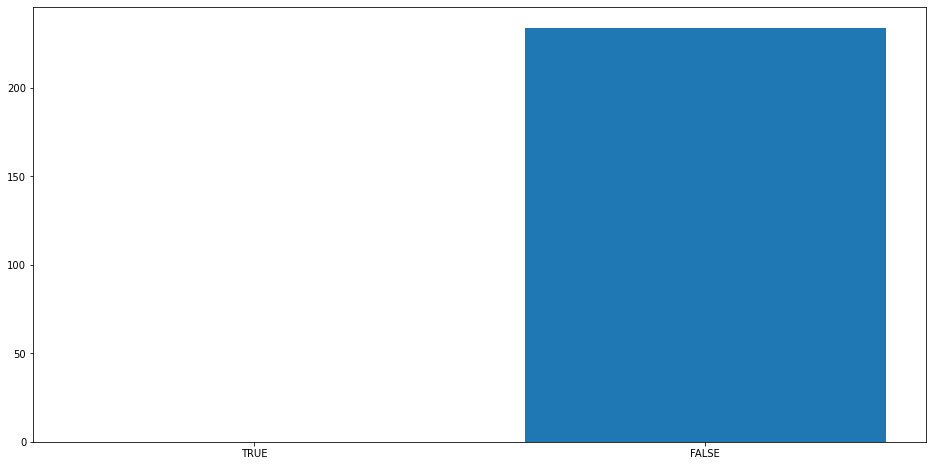

In [23]:
occurs=[np.sum(y_prediction== True),np.sum(y_prediction== False)]
authors=['TRUE','FALSE']

fig = plt.figure(figsize=(16,8))
plt.bar(authors,occurs)
plt.savefig("linear_graphic.jpg")
plt.show()

## Logistic Model

In [24]:
#do not run again
clf = LogisticRegression()

parameter_grid = {
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200,250]
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1780s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0567s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 113 out of 120 | elapsed:    4.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.5s finished
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The 

Best Parameter Choice:
{'max_iter': 100, 'penalty': 'none', 'solver': 'newton-cg'}


/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/op

In [25]:
clf = make_pipeline(cv_grid.best_estimator_)

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['LogRegression'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/op

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/op

In [26]:
clf2 = make_pipeline(cv_grid.best_estimator_)

clf2.fit(X_train, y_train)

results_overview['LogRegression']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/op

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/scipy/op

{'LinearSVC': {'accuracy': 0.6631578947368421,
  'balanced_accuracy': 0.5256283068783069,
  'f1_weighted': 0.5754946105088344,
  'fit_time': 0.022646347681681316,
  'Holdout': 0.631578947368421},
 'LogRegression': {'accuracy': 0.9473684210526315,
  'balanced_accuracy': 0.9295634920634921,
  'f1_weighted': 0.9464395895090304,
  'fit_time': 0.32181310653686523,
  'Holdout': 0.9052631578947369}}

In [29]:
f = open("log_result.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_prediction[i])+'\n')
f.close()

f = open("log_result2.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_houldout_prediction[i])+'\n')
f.close()

['TRUE', 'FALSE']


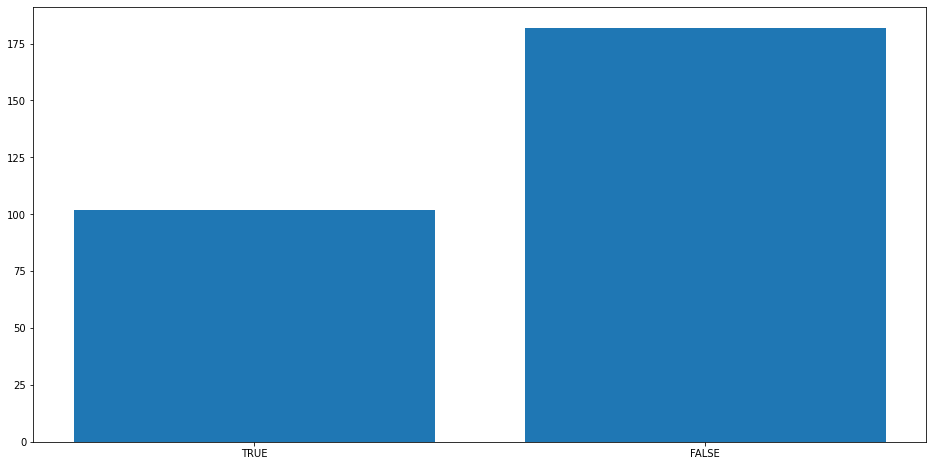

In [30]:
occurs=[np.sum(y_prediction== True),np.sum(y_prediction== False)]
authors=['TRUE','FALSE']
    
print(authors)
fig = plt.figure(figsize=(16,8))
plt.bar(authors,occurs)
plt.savefig("log_graphic.jpg")
plt.show()

# Random Forest

In [31]:
#do not run again
clf = RandomForestClassifier()

parameter_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.4s finished


Best Parameter Choice:
{'criterion': 'entropy', 'max_features': 'auto'}


In [32]:
clf = make_pipeline(cv_grid.best_estimator_)

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['RandomForestClassifier'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

In [33]:
clf2 = make_pipeline(cv_grid.best_estimator_)

clf2.fit(X_train, y_train)

results_overview['RandomForestClassifier']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)

{'LinearSVC': {'accuracy': 0.6631578947368421,
  'balanced_accuracy': 0.5256283068783069,
  'f1_weighted': 0.5754946105088344,
  'fit_time': 0.022646347681681316,
  'Holdout': 0.631578947368421},
 'LogRegression': {'accuracy': 0.9473684210526315,
  'balanced_accuracy': 0.9295634920634921,
  'f1_weighted': 0.9464395895090304,
  'fit_time': 0.32181310653686523,
  'Holdout': 0.9052631578947369},
 'RandomForestClassifier': {'accuracy': 0.9684210526315788,
  'balanced_accuracy': 0.9556878306878307,
  'f1_weighted': 0.9680431664711441,
  'fit_time': 0.16197848320007324,
  'Holdout': 0.9368421052631579}}

In [34]:
f = open("RandomTree_result.csv", "w")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_prediction[i])+'\n')
f.close()

f = open("RandomTree_result2.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_houldout_prediction[i])+'\n')
f.close()

['TRUE', 'FALSE']


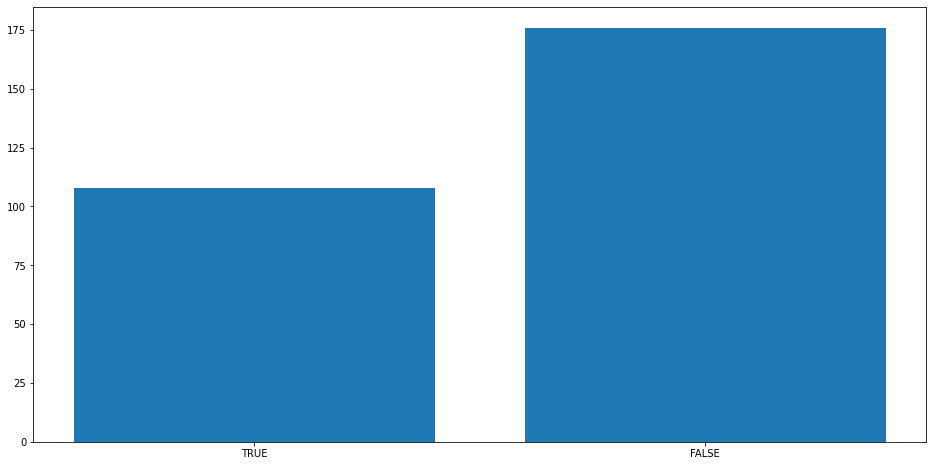

In [35]:
occurs=[np.sum(y_prediction== True),np.sum(y_prediction== False)]
authors=['TRUE','FALSE']
    
print(authors)
fig = plt.figure(figsize=(16,8))
plt.bar(authors,occurs)
plt.savefig("RandomTree_graphic.jpg")
plt.show()

## Kneighbors

In [36]:
#do not run again
clf = KNeighborsClassifier()

parameter_grid = {
    'weights':['uniform', 'distance']
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameter Choice:
{'weights': 'distance'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0384s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


In [37]:
clf = make_pipeline(cv_grid.best_estimator_)

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['NeighborsClassifier'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }



In [38]:
clf2 = make_pipeline(cv_grid.best_estimator_)

clf2.fit(X_train, y_train)

results_overview['NeighborsClassifier']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)

{'LinearSVC': {'accuracy': 0.6631578947368421,
  'balanced_accuracy': 0.5256283068783069,
  'f1_weighted': 0.5754946105088344,
  'fit_time': 0.022646347681681316,
  'Holdout': 0.631578947368421},
 'LogRegression': {'accuracy': 0.9473684210526315,
  'balanced_accuracy': 0.9295634920634921,
  'f1_weighted': 0.9464395895090304,
  'fit_time': 0.32181310653686523,
  'Holdout': 0.9052631578947369},
 'RandomForestClassifier': {'accuracy': 0.9684210526315788,
  'balanced_accuracy': 0.9556878306878307,
  'f1_weighted': 0.9680431664711441,
  'fit_time': 0.16197848320007324,
  'Holdout': 0.9368421052631579},
 'NeighborsClassifier': {'accuracy': 0.7228070175438597,
  'balanced_accuracy': 0.6372354497354498,
  'f1_weighted': 0.699176195434195,
  'fit_time': 0.0076266129811604815,
  'Holdout': 0.7578947368421053}}

In [40]:
f = open("NeighborsClassifier_result.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_prediction[i])+'\n')
f.close()

f = open("NeighborsClassifier_result2.csv", "a")
f.write('ID,MALIGNANT\n')
for i in range(284):
    f.write(str(X_res['ID'][i])+','+str(y_houldout_prediction[i])+'\n')
f.close()

['TRUE', 'FALSE']


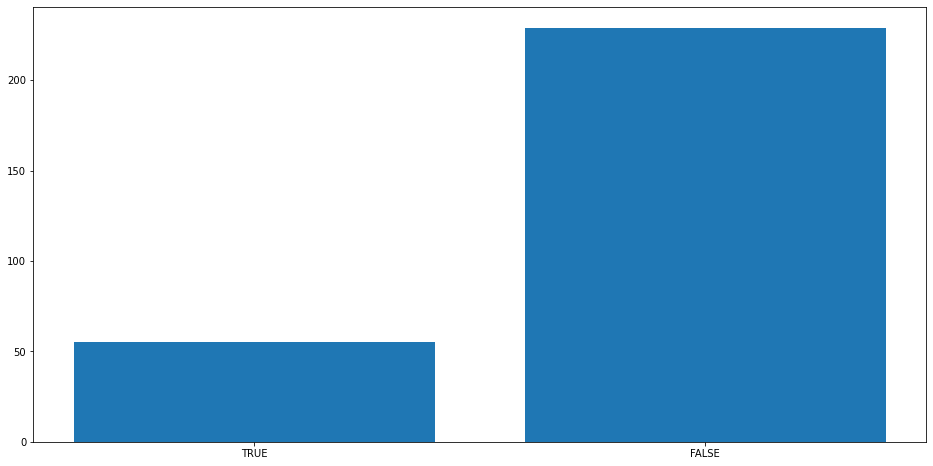

In [41]:
occurs=[np.sum(y_prediction== True),np.sum(y_prediction== False)]
authors=['TRUE','FALSE']
    
print(authors)
fig = plt.figure(figsize=(16,8))
plt.bar(authors,occurs)
plt.savefig("Neigbors_graphic.jpg")
plt.show()

In [42]:
pd.DataFrame.from_dict(results_overview).T

,accuracy,balanced_accuracy,f1_weighted,fit_time,Holdout
LinearSVC,0.663158,0.525628,0.575495,0.022646,0.631579
LogRegression,0.947368,0.929563,0.946440,0.321813,0.905263
RandomForestClassifier,0.968421,0.955688,0.968043,0.161978,0.936842
NeighborsClassifier,0.722807,0.637235,0.699176,0.007627,0.757895
